In [32]:
import os
import sys
import pandas as pd
import numpy as np
from scipy import stats
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

PROJECT_PATH = os.path.join(os.getcwd(), '../')

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
    
from server.ml_models.all_model import AllModelData
from server.ml_models.match_model import CATEGORY_COLS
from server.ml_models import EnsembleModel
from server.ml_models.data_config import TEAM_NAMES, ROUND_TYPES, VENUES

from src.model.metrics import yearly_performance_scores
from src.model.charts import graph_yearly_model_performance

SEED = 42
N_ITER = 5
CV = 5

np.random.seed(SEED)

In [2]:
data = AllModelData(train_years=(None, 2015), test_years=(2016, 2016))
X_train, y_train = data.train_data()
X_train

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


team         oppo_team round_type  \
Adelaide         1991 1           Adelaide          Hawthorn    Regular   
                      2           Adelaide           Carlton    Regular   
                      3           Adelaide            Sydney    Regular   
                      4           Adelaide          Essendon    Regular   
                      5           Adelaide        West Coast    Regular   
                      6           Adelaide  Western Bulldogs    Regular   
                      7           Adelaide          St Kilda    Regular   
                      9           Adelaide   North Melbourne    Regular   
                      10          Adelaide         Melbourne    Regular   
                      11          Adelaide           Geelong    Regular   
                      12          Adelaide           Fitzroy    Regular   
                      13          Adelaide          Richmond    Regular   
                      14          Adelaide          Brisbane    Regular   
                      15          Adelaide       Collingwood    Regular   
                      16          Adelaide          Hawthorn    Regular   
                      17          Adelaide           Carlton    Regular   
                      18          Adelaide            Sydney    Regular   
                      19          Adelaide          Essendon    Regular   
                      20          Adelaide        West Coast    Regular   
                      21          Adelaide  Western Bulldogs    Regular   
                      22          Adelaide          St Kilda    Regular   
                      24          Adelaide   North Melbourne    Regular   
                 1992 1           Adelaide  Western Bulldogs    Regular   
                      3           Adelaide         Melbourne    Regular   
                      4           Adelaide           Fitzroy    Regular   
                      5           Adelaide          Richmond    Regular   
                      6           Adelaide          Brisbane    Regular   
                      7           Adelaide          St Kilda    Regular   
                      8           Adelaide           Geelong    Regular   
                      9           Adelaide       Collingwood    Regular   
...                                    ...               ...        ...   
Western Bulldogs 2015 21  Western Bulldogs        West Coast    Regular   
                      22  Western Bulldogs   North Melbourne    Regular   
                      23  Western Bulldogs          Brisbane    Regular   
                      24  Western Bulldogs          Adelaide     Finals   
                 2016 1   Western Bulldogs         Fremantle    Regular   
                      2   Western Bulldogs          St Kilda    Regular   
                      3   Western Bulldogs          Hawthorn    Regular   
                      4   Western Bulldogs           Carlton    Regular   
                      5   Western Bulldogs          Brisbane    Regular   
                      6   Western Bulldogs   North Melbourne    Regular   
                      7   Western Bulldogs          Adelaide    Regular   
                      8   Western Bulldogs         Melbourne    Regular   
                      9   Western Bulldogs               GWS    Regular   
                      10  Western Bulldogs       Collingwood    Regular   
                      11  Western Bulldogs        West Coast    Regular   
                      12  Western Bulldogs     Port Adelaide    Regular   
                      13  Western Bulldogs           Geelong    Regular   
                      15  Western Bulldogs            Sydney    Regular   
                      16  Western Bulldogs          Richmond    Regular   
                      17  Western Bulldogs        Gold Coast    Regular   
                      18  Western Bulldogs          St Kilda    Regular   
                      19  Western Bulldogs           Geelong   

In [37]:
model = EnsembleModel()
params = {
    'pipeline__baggingregressor__n_estimators': stats.randint(5, 15),
    'pipeline__baggingregressor__base_estimator__booster': ['gbtree', 'gblinear', 'dart'],
    'pipeline__baggingregressor__base_estimator__colsample_bylevel': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__colsample_bytree': stats.uniform(0.8, 0.2),
    'pipeline__baggingregressor__base_estimator__learning_rate': stats.uniform(0.075, 0.05),
    'pipeline__baggingregressor__base_estimator__max_depth': stats.randint(2, 10),
    'pipeline__baggingregressor__base_estimator__n_estimators': stats.randint(75, 150),
    'pipeline__baggingregressor__base_estimator__reg_alpha': stats.uniform(0.0, 0.2),
    'pipeline__baggingregressor__base_estimator__reg_lambda': stats.uniform(0.75, 0.5),
    'pipeline__baggingregressor__base_estimator__subsample': stats.uniform(0.8, 0.2),
}

bag_cv = RandomizedSearchCV(model, params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=CV,
                            n_iter=N_ITER, random_state=SEED)

In [38]:
bag_cv.fit(*data.train_data())

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=EnsembleModel(name='EnsembleModel',
       pipeline=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None,
         remainder=StandardScaler(copy=True, with_mean=True, with_std=True),
         sparse_threshold=0.3, transformer_weights=None,
         transformers=[('onehotencoder', OneHotEncoder(categorical_features=None,
       categories=[['Ade...imators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])),
          fit_params=None, iid='warn', n_iter=5, n_jobs=1,
          param_distributions={'pipeline__baggingregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0b3d6952b0>, 'pipeline__baggingregressor__base_estimator__booster': ['gbtree', 'gblinear', 'dart'], 'pipeline__baggingregressor__base_estimator__colsample_bylevel': <scipy.stat..._base_estimator__subsample': <scipy.stats._distn_infrastructure.

In [39]:
bag_cv.best_score_, bag_cv.best_params_

(-26.146526068373788,
 {'pipeline__baggingregressor__base_estimator__booster': 'gbtree',
  'pipeline__baggingregressor__base_estimator__colsample_bylevel': 0.8092900825439996,
  'pipeline__baggingregressor__base_estimator__colsample_bytree': 0.9215089703802877,
  'pipeline__baggingregressor__base_estimator__learning_rate': 0.08352620618436457,
  'pipeline__baggingregressor__base_estimator__max_depth': 8,
  'pipeline__baggingregressor__base_estimator__n_estimators': 92,
  'pipeline__baggingregressor__base_estimator__reg_alpha': 0.18977710745066667,
  'pipeline__baggingregressor__base_estimator__reg_lambda': 1.2328160165372797,
  'pipeline__baggingregressor__base_estimator__subsample': 0.9616794696232923,
  'pipeline__baggingregressor__n_estimators': 13})

In [41]:
data.train_years = (None, 2016)
X_train_yr, y_train_yr = data.train_data()

scores = yearly_performance_scores([('ensemble', model, {})], X_train_yr, y_train_yr, data_frame=True, parallel=False)

scores

Getting scores for 2011
	Getting scores for ensemble
Getting scores for 2012
	Getting scores for ensemble
Getting scores for 2013
	Getting scores for ensemble
Getting scores for 2014
	Getting scores for ensemble
Getting scores for 2015
	Getting scores for ensemble
Getting scores for 2016
	Getting scores for ensemble


,accuracy,error,model,year
0,0.770408,29.663516,ensemble,2011
1,0.809179,27.644323,ensemble,2012
2,0.748792,27.009301,ensemble,2013
3,0.736715,28.606562,ensemble,2014
4,0.718447,30.179641,ensemble,2015
5,0.714976,28.206680,ensemble,2016


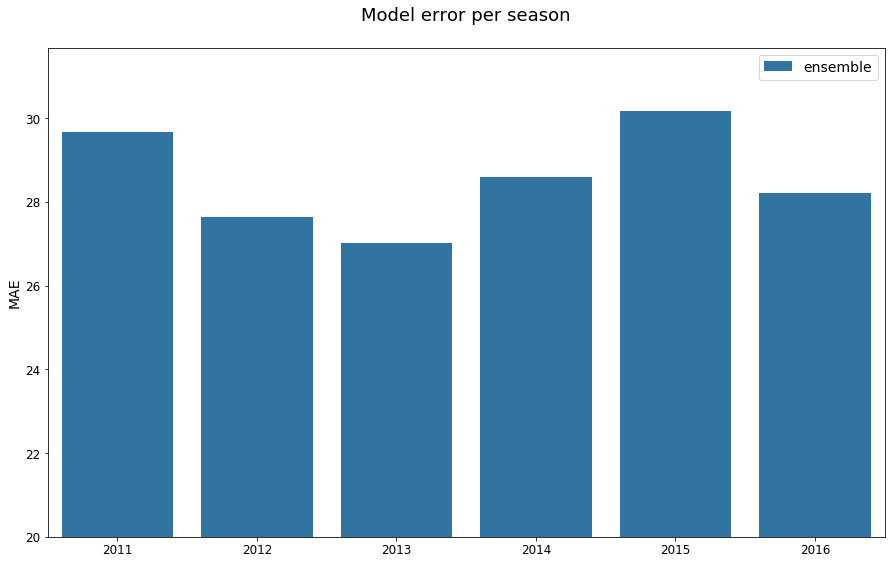

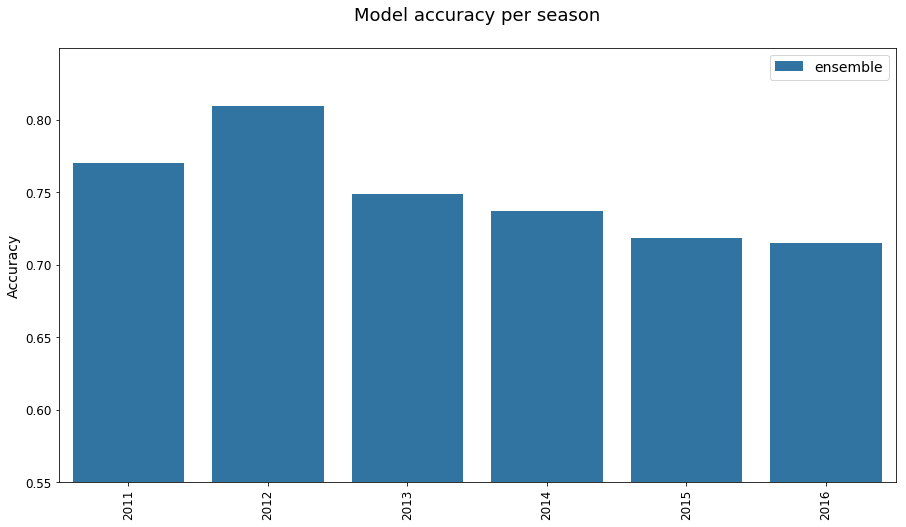

In [42]:
graph_yearly_model_performance(scores)

In [43]:
scores.groupby('model').mean()[['error', 'accuracy']]

,error,accuracy
model,,
ensemble,28.551671,0.749753
